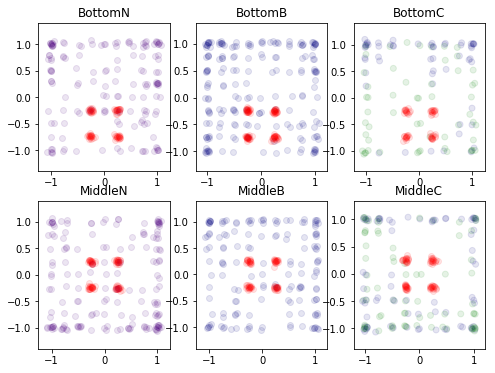

In [20]:
import pymc3 as pm
import numpy as np
import sqlite3, os
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re

from matplotlib.patches import Ellipse
import theano.tensor as tt
from theano.tensor.nlinalg import det, matrix_inverse
#Gaussian Mixture Model! Now to multivariateness!
execfile('Imports.py')
import Modules.Funcs as funcs
%matplotlib inline

pd.set_option('precision', 2)
#Fetch pooled data


# import raw-ish data
con = sqlite3.connect('../data/experiment.db')
info = pd.read_sql_query("SELECT * from participants", con)
df = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).as_matrix()

con.close()

savedir = './'
gentypeStr = ['N','B','C'] #not alpha, only beta, beta-gamma
gentypeStrDisp = ['A\'','B','C'] #not alpha, only beta, beta-gamma
conditionLabels = ['Bottom','Middle']
gentypeCols = [[.3,0,.5],[0,0,.5],[0,.5,0]]
pooled_alphas = dict()#np.empty((0, 2))
pooled_betas  = dict()#np.empty((0, 2))
cond_all = []

f, ax= plt.subplots(2,3, figsize=(8, 6))
alpha = .1
jittersd = .03
for i, row in info.iterrows():
    pid, condition, gentype = int(row.participant), row.condition, row.gentype
    condNum = conditionLabels.index(condition)
    gentypeStr_p = gentypeStr[gentype]
    #condInd = condNum*3+gentype #condition index
    condName = condition + gentypeStr_p
    palphas = alphas[condition]    
    pbetas = df.stimulus[df.participant == pid]
    if gentype==2:
        pdf = df.loc[df.participant==pid]
        betastr = [gentypeStrDisp[1] if pdf_row.category=='Beta' else gentypeStrDisp[2] for ii,pdf_row in pdf.iterrows() ]
        betacol = [gentypeCols[1] if pdf_row.category=='Beta' else gentypeCols[2] for ii,pdf_row in pdf.iterrows() ]
    else:
        betastr = gentypeStrDisp[gentype]
        betacol = gentypeCols[gentype]
        
    #stack data
    stacka = stimuli[palphas.as_matrix()] 
    stackb = stimuli[pbetas.as_matrix()]
    #Funnel data into appropriate separate conditions
    if not condName in pooled_alphas.keys():
        pooled_alphas[condName] = np.empty((0,2))
        pooled_betas[condName]  = np.empty((0,2))
    else:        
        pooled_alphas[condName] = np.concatenate((pooled_alphas[condName],stacka), axis=0)
        pooled_betas[condName] = np.concatenate((pooled_betas[condName],stackb), axis=0)
    
    cond_all += [condName]

    #jitter data for plotting
    stacka_plot = stacka + np.random.normal(0,jittersd,size=stacka.shape)
    stackb_plot = stackb + np.random.normal(0,jittersd,size=stackb.shape)

    currax = ax[condNum][gentype]
    currax.scatter(stacka_plot[:,0],stacka_plot[:,1],color='r',alpha=alpha)
    currax.scatter(stackb_plot[:,0],stackb_plot[:,1],color=betacol,alpha=alpha)
    currax.set_title(condName)
    currax.axis('equal')

cond_all = list(np.unique(cond_all))
#def plot_data(ax,alphas,betas):
    

In [21]:
#Smush the data into a single array
data_all = dict()
for cn in cond_all:
    data_all[cn] = dict()
    data_all[cn]['data'] = np.concatenate((pooled_alphas[cn],pooled_betas[cn]),axis=0)
# condName = 'BottomN'
# data = np.concatenate((pooled_alphas[condName],pooled_betas[condName]),axis=0)


In [22]:
#Define models
niter = 1000
#traces = []
for cn in cond_all:
    data = data_all[cn]['data']
    data_all[cn]['traces'] = []
    gmm_all = [pm.Model() for i in range(3)]
    for mi in range(3):    
        with gmm_all[mi]:
            k = mi+1
            #Prior
            if k>1:    
                p = pm.Dirichlet('p', a=np.array([1.]*k), testval=np.ones(k)/k)

            mus = [pm.MvNormal('mu_%d' % i,
                                mu=pm.floatX(np.zeros(2)),
                                tau=pm.floatX(0.1 * np.eye(2)),
                                shape=(2,))
                   for i in range(k)]

            packed_L = [pm.LKJCholeskyCov('packed_L_%d' % i,n=2,eta=2.,sd_dist=pm.HalfCauchy.dist(2.5))
                        for i in range(k)]
            L = [pm.expand_packed_triangular(2, packed_L[i])
                 for i in range(k)]
            sigma = [pm.Deterministic('sigma_%d' % i ,L[i].dot(L[i].T))
                     for i in range(k)]
            tau = [pm.Deterministic('tau_%d' % i,matrix_inverse(sigma[i]))
                   for i in range(k)]

            if k>1:
                mvnl = [pm.MvNormal.dist(mu=mus[i],chol=L[i]) 
                       for i in range(k)]
                Y_obs = pm.Mixture('Y_obs',w=p, comp_dists=mvnl,observed=data)
            else:
                Y_obs = pm.MvNormal('Y_obs',mu=mus[0],chol=L[0],observed=data)

            #step = pm.NUTS(vars=[p, mus[0],mus[1],mus[2],
            #                            packed_L[0],packed_L[1],packed_L[2]])
            step = pm.Metropolis() #this would work too, right? no need to specify vars
            #Start the sampler!
            data_all[cn]['traces'] += [pm.sample(niter, step=step)]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [packed_L_0]
>Metropolis: [mu_0]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [packed_L_1]
>Metropolis: [packed_L_0]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
>Metropolis: [p]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [packed_L_2]
>Metropolis: [packed_L_1]
>Metropolis: [packed_L_0]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
>Metropolis: [p]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [packed_L_0]
>Metrop

In [23]:
data_all['BottomC']['traces']

[<MultiTrace: 4 chains, 1000 iterations, 5 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 12 variables>,
 <MultiTrace: 4 chains, 1000 iterations, 17 variables>]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a448b10>,
      dtype=object)

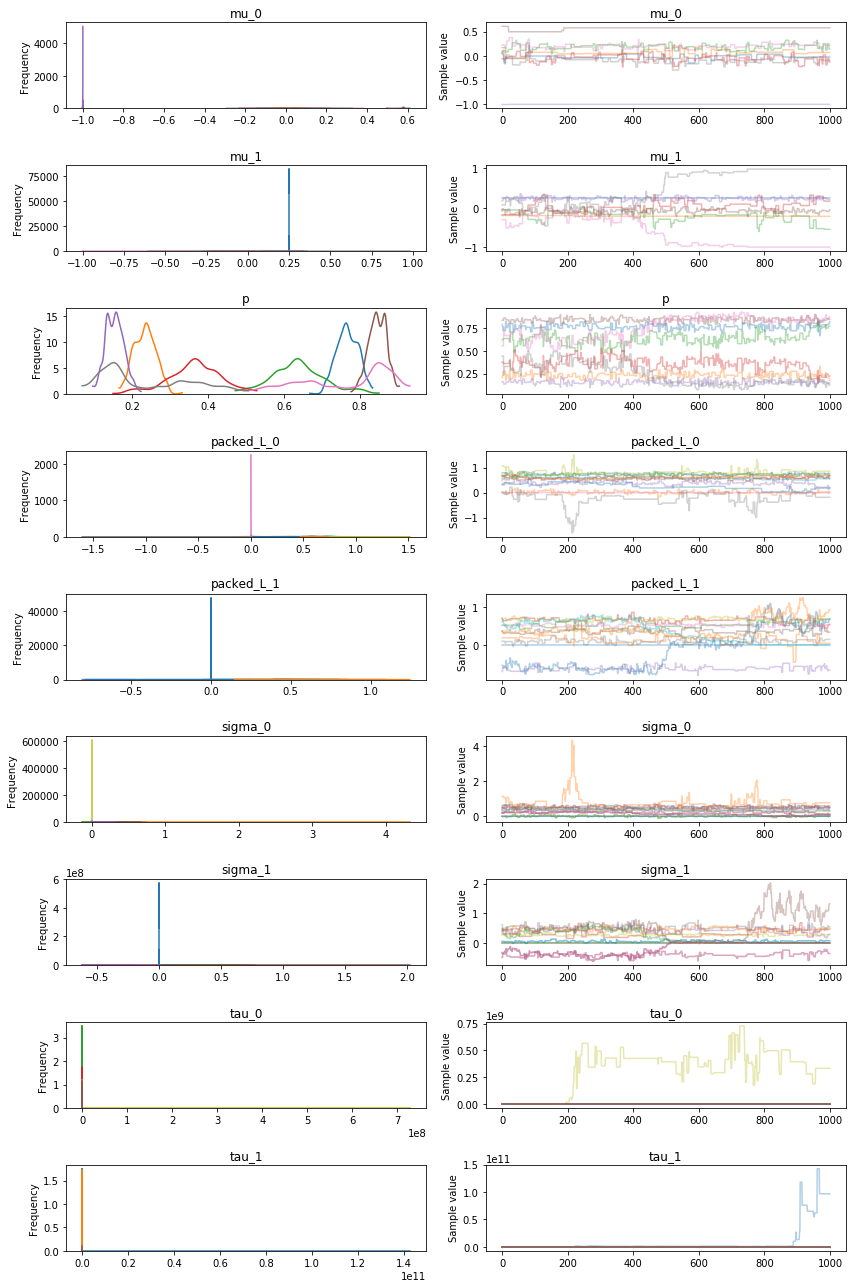

In [24]:
pm.traceplot(data_all['BottomN']['traces'][1])



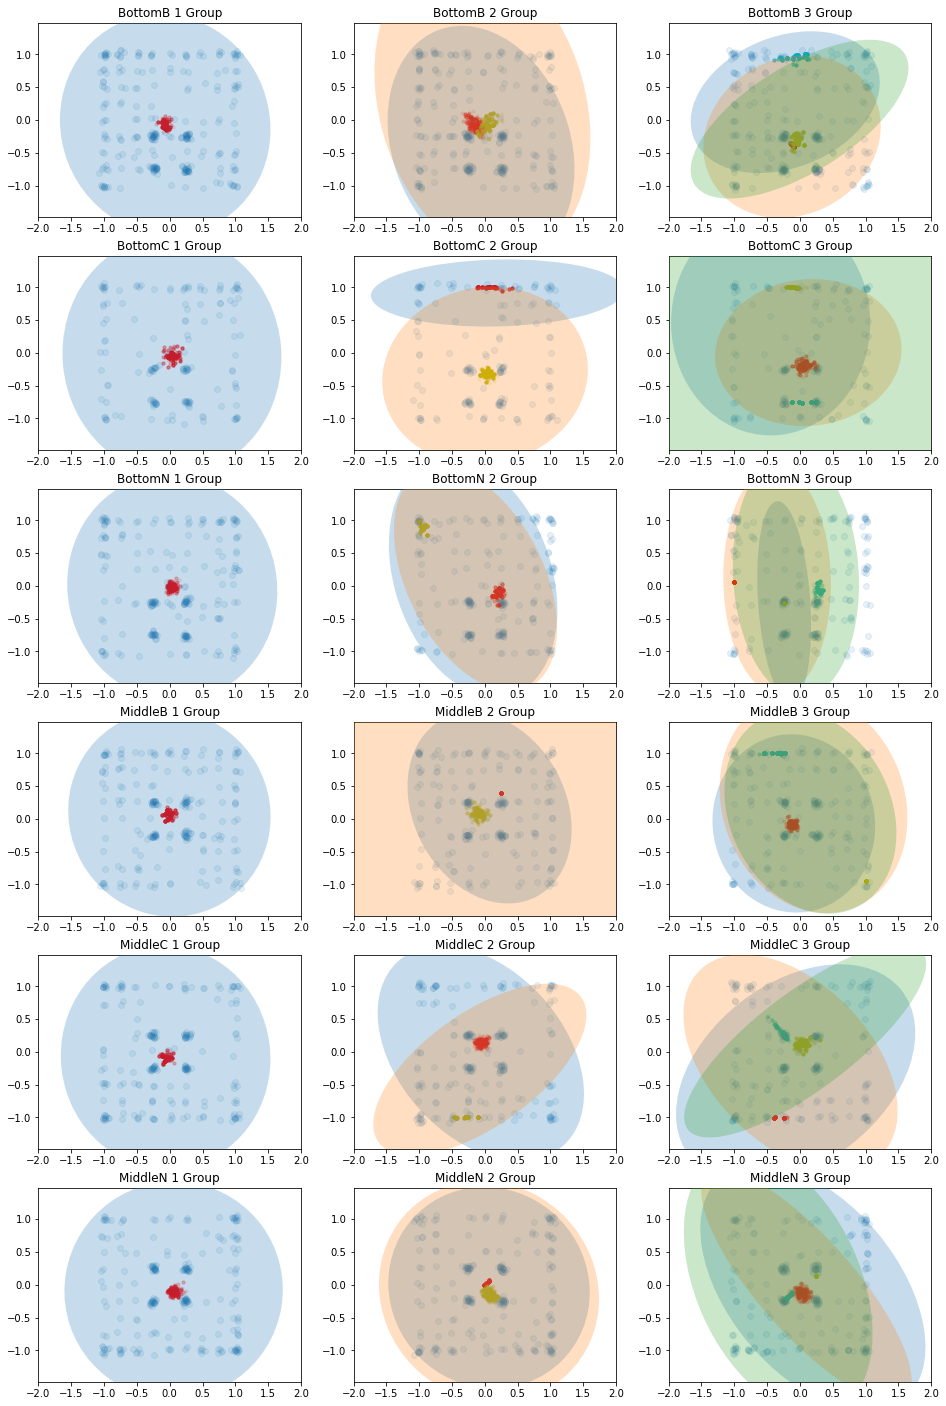

In [25]:
#Let's have a look at the posterior predictives?

def plot_ellipse(ax,ms,ss):
    colors = sns.color_palette()
    k = ms.shape[0]
    for i in range(k):
        colr = colors[i]
        var, U = np.linalg.eig(ss[i])
#         print U
#         print np.arccos(np.abs(U[0, 0]))
        angle = 180. / np.pi * np.arccos(np.abs(U[0, 0])) #* np.sign(ss[i][1,0])
#         print angle
        e = Ellipse(ms[i,:], 2 * np.sqrt(5.991 * var[0]),
                    2 * np.sqrt(5.991 * var[1]),
                    angle=angle)
        e.set_alpha(0.25)
        e.set_facecolor(colr)
        e.set_zorder(10);
        ax.add_artist(e);
        
fig,ax_all = plt.subplots(6,3,figsize=(16,25))
# jitterx = data[:,0] + np.random.normal(0,jittersd,size=data[:,0].shape)
# jittery = data[:,1] + np.random.normal(0,jittersd,size=data[:,0].shape)
# ax.scatter(jitterx,jittery,alpha=.5)

#Posterior predictives
# traces = [trace1,trace2,trace3]
for ci,cn in enumerate(cond_all):
    data = data_all[cn]['data']
    traces = data_all[cn]['traces']
    for ti,trace in enumerate(traces):
        gmm_all[ti].name = str(ti+1) + ' Group'
        jitterx = data[:,0] + np.random.normal(0,jittersd,size=data[:,0].shape)
        jittery = data[:,1] + np.random.normal(0,jittersd,size=data[:,0].shape)
        ax = ax_all[ci,ti]
        ax.scatter(jitterx,jittery,alpha=.1)
        #trace = trace1
        ms_str = [re.findall('mu_.*',string) for string in trace.varnames if len(re.findall('mu_.*',string))>0]
        ss_str = [re.findall('sigma_.*',string) for string in trace.varnames if len(re.findall('sigma_.*',string))>0]
        #Extract posteriors from trace - take about the later half worth of samples?
        ms_post = np.array([np.array([trace[m_str[0]][-int(-niter/2):,0].mean(), trace[m_str[0]][-int(-niter/2):,1].mean()]) 
                   for m_str in ms_str])
        ss_post = np.array([np.array([[trace[s_str[0]][-int(-niter/2):,0,0].mean(), trace[s_str[0]][-int(-niter/2):,0,1].mean()],
                            [trace[s_str[0]][-int(-niter/2):,1,0].mean(), trace[s_str[0]][-int(-niter/2):,1,1].mean()]]) 
                   for s_str in ss_str])

        ax.scatter(trace[ms_str[0][0]][-500:, 0], trace[ms_str[0][0]][-500:, 1], c="r", s=10,alpha=alpha)
        if ti>0:
            ax.scatter(trace[ms_str[1][0]][-500:, 0], trace[ms_str[1][0]][-500:, 1], c="y", s=10,alpha=alpha)
        if ti>1:
            ax.scatter(trace[ms_str[2][0]][-500:, 0], trace[ms_str[2][0]][-500:, 1], c="c", s=10,alpha=alpha)


        plot_ellipse(ax,ms_post,ss_post)
        ax.axis('equal')
        ax.set_ylim(-2,2)
        ax.set_xlim(-2,2)
        ax.set_title(cn + ' ' + str(ti+1) + ' Group')

In [26]:
# Do some model comparison
for cn in cond_all:
    print cn
    traces = data_all[cn]['traces']
    #ppc = pm.sample_ppc(trace,samples=1,model=gmm) #doesn't seem to work?
    # waic = pm.waic(trace3,model=gmm3)
    compareWAIC = pm.compare({gmm_all[0]:traces[0],gmm_all[1]:traces[1],gmm_all[2]:traces[2]})
    print compareWAIC
    #pm.compareplot(compareWAIC);

    #try LOO
    compareLOO = pm.compare({gmm_all[0]:traces[0],gmm_all[1]:traces[1],gmm_all[2]:traces[2]},ic='LOO')
    print compareLOO
    #pm.compareplot(compareLOO);

BottomB


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


            WAIC    pWAIC    dWAIC weight       SE      dSE var_warn
1 Group    1e+03      3.7        0      1       26        0        0
2 Group  1.2e+03  2.9e+02    2e+02      0       22       20        1
3 Group  2.1e+03  1.1e+03  1.1e+03      0  1.2e+02  1.3e+02        1
             LOO     pLOO dLOO weight  SE dSE shape_warn
1 Group    1e+03      3.7    0   0.83  26   0          0
3 Group  1.1e+03    6e+02   61   0.17  26  20          0
2 Group  1.1e+03  2.3e+02   66      0  25  11          0
BottomC


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


            WAIC    pWAIC    dWAIC weight  SE dSE var_warn
1 Group    1e+03      6.3        0   0.56  23   0        0
2 Group    1e+03       71      4.5   0.44  24  21        1
3 Group  1.2e+03  3.4e+02  2.1e+02      0  44  37        1


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


           LOO     pLOO dLOO weight  SE dSE shape_warn
2 Group  1e+03       67    0   0.29  24   0          1
1 Group  1e+03      6.3  3.2   0.54  23  22          0
3 Group  1e+03  2.4e+02   29   0.17  26  17          0
BottomN


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


            WAIC    pWAIC    dWAIC weight     SE      dSE var_warn
1 Group  9.9e+02      4.8        0      1     25        0        0
2 Group  1.8e+03  9.7e+02  8.2e+02      0     68       68        1
3 Group  2.7e+03  1.8e+03  1.7e+03      0  1e+02  1.1e+02        1
             LOO     pLOO dLOO weight  SE dSE shape_warn
3 Group  9.3e+02  9.5e+02    0   0.73  32   0          0
2 Group  9.9e+02  5.6e+02   61      0  28  19          0
1 Group  9.9e+02      4.8   65   0.27  25  25          0
MiddleB


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


            WAIC    pWAIC    dWAIC weight       SE      dSE var_warn
1 Group    1e+03      5.8        0      1       29        0        0
3 Group  3.1e+03  2.1e+03  2.1e+03      0  1.7e+02  1.7e+02        1
2 Group  3.6e+03  2.3e+03  2.6e+03      0  2.5e+02  2.3e+02        1


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


             LOO     pLOO     dLOO weight  SE dSE shape_warn
3 Group  8.8e+02  9.8e+02        0   0.94  31   0          1
2 Group  9.7e+02  9.8e+02       93   0.06  28  24          0
1 Group    1e+03      5.8  1.3e+02      0  29  26          0
MiddleC


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


            WAIC    pWAIC dWAIC weight  SE dSE var_warn
3 Group  9.8e+02  4.4e+02     0   0.47  38   0        1
1 Group    1e+03      4.6    19   0.53  26  35        0
2 Group  1.1e+03  3.4e+02    79      0  28  25        1


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


             LOO     pLOO     dLOO weight  SE dSE shape_warn
3 Group    8e+02  3.5e+02        0   0.89  39   0          1
2 Group  9.6e+02  2.9e+02  1.6e+02      0  27  21          0
1 Group    1e+03      4.6    2e+02   0.11  26  34          0
MiddleN


/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python2.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


            WAIC    pWAIC    dWAIC weight       SE      dSE var_warn
1 Group  9.9e+02      4.5        0   0.69       25        0        0
2 Group  9.9e+02  2.7e+02      5.7   0.25       26       14        1
3 Group  2.3e+03  1.7e+03  1.3e+03   0.06  1.1e+02  1.1e+02        1
             LOO     pLOO     dLOO weight  SE dSE shape_warn
3 Group  7.7e+02  9.4e+02        0   0.98  41   0          0
2 Group  9.4e+02  2.4e+02  1.7e+02      0  28  26          0
1 Group  9.9e+02      4.5  2.2e+02   0.02  25  37          0
